# GAPminder世界发展数据探索

## 指引

根据你选择的衡量指标，有些国家发展的比其他好吗？是否能根据该衡量指标观察出某种趋势？

你可以在[数据集选项](https://github.com/udacity/new-dand-basic-china/blob/master/%E6%95%B0%E6%8D%AE%E5%88%86%E6%9E%90%E5%85%A5%E9%97%A8/%E9%A1%B9%E7%9B%AE-%E6%8E%A2%E7%B4%A2%E6%95%B0%E6%8D%AE%E9%9B%86/%E6%8E%A2%E7%B4%A2%E6%95%B0%E6%8D%AE%E9%9B%86%20-%20%E5%A4%87%E9%80%89%E6%95%B0%E6%8D%AE%E9%9B%86.md) 中找到一些问题，以帮助你入手。 试着提出那些调查多个变量之间的关系的问题。你应该在你的调查里分析至少一个因变量和三个自变量。在恰当的地方使用 NumPy 和 Pandas。

## 初步分析

意向性之一:

验证李普赛特和罗伯特·达尔提到的民主模型，但有这样几个阻碍：

>1、民主是一个很难量化的内容，到底是选举的投票率呢？还是精英的竞争程度呢？似乎并不清楚。
>
>2、数据来源问题。是这个数据集采用是Polity IV的标准，这个的数据长时期稳定在很低的水平不变。
>
>替代方案：能否采用比较权威的民主指数比如经济学人发布的[指数](https://en.wikipedia.org/wiki/Democracy_Index)，或者以更具体的民主因素作为指数，比如清廉指数、[腐败感知指数](https://pardee.du.edu/)，此外还有IDEA做的[更细致的划分](https://www.idea.int/gsod-indices/#/indices/world-map)：政府代表制、基本权利、政府制衡、行政中立等等。但很快遇到了一个问题就是很多数据都不那么好获取。[预测民主的模型](https://pardee.du.edu/access-ifs)。

意向性之二：

分析一个国家经济成长的原因。

> GDP的增速数据并没有提供，于是代之以人均收入的PPP数据统计。什么可能和人均收入相关呢？以中国为例，当然是改革和开放的功劳，改革应该表现为私有部门和市场的扩大，而开放意味着外资流入的增加，其他原因应该还包括科技投入增加、教育年限的提高等等

意向性之三：

人类发展指数和政治经济的一些元素的关联性的有多大？

最终评估，第一意向的数据比较难获取。第三意向的解释难度不大。第二意向比较有趣，虽然有很多直接数据选择有困难，但可以采用替代的方法进行分析。

## 操作

### 指标选择

经济成长=市场经济活力+对外开放+教育进步

经济成长选择人均收入的作为指标，真正体现民富，可能相对于人均GDP略有不同，但意义更大。市场经济活力，因为私营部门的比例数据缺失，所以选择服务业就业人数比例，因为服务业一般来说往往是第二产业的延伸，私营性质最强。对外开放选取贸易指数即进出口占GDP比重进行操作。教育进步选择15-24岁女性接受教育的平均年限，这一指标相对全面衡量全体国民的基本教育水平。

### 数据整理

第一个数据集df_service中有大量缺失，思路是用线性插值法进行填充，但是一开始列索引设置在「geo」前的数字上，无法进行行插值，所以当时采用分离表的方法，先把「geo」右侧的列分出去、插值，再组装回来。事实证明比较繁琐，而且容易出现重复的问题。

```python
#下一步把NaN用线性插值法整理,但因为第一个列标签不是浮点数，所以先拿开
df_servicer=df_service.iloc[0:,1:]
df_servicer.interpolate(method = 'linear',axis=1,inplace=True)

#重新链接两个表
df_service = pd.concat([df_service.iloc[0:,0:1], df_servicer], axis=1)

#但上述操作方法但成本未免太高，因此想到更改index的方法。
df_service=df_service.set_index('geo')
```

顺利完成后，又使用前向填充法，把缺失的值全部补上。

然后发现几个不同的指标数据差异非常大，为了能在分析中方便可视化，并突出变化特征，将收入变化和教育年限两个具体数值换算为近半个世纪以来的变化率，生成新的表格。

之后连接4个表格。

```python
df_total = pd.concat([new_df_income,new_df_service,new_df_trade,new_df_edu], axis=1,sort=True)
```

删除因数据集不同而产生的缺失值。

### 数据探索

我需要证明的是因变量income变动和自变量第三产业就业率变动、贸易率变动、教育率变动三者之间的相关性。

首先使用相关系数进行探索：提前查到相关系数的[分级解释](https://www.statisticssolutions.com/pearsons-correlation-coefficient/)，系数在0.5-1之间才可以判定为强相关，在0.3-0.49之间为中等相关，而低于0.29被认为是相关性很低了。

先看看总表，可以发现因变量与自变量的相关性都不高，甚至和教育年限的变化率呈现负相关，这很令我们困惑。

![](https://i.imgur.com/CDtWVQr.jpg)

猜测是不同类型的国家太多造成了混淆，因此予以分类。根据四分位数进行尝试。先是小于中位数的一半国家，相关性低。

![](https://i.imgur.com/eDHFSYk.jpg)

再是大于中位数的另外一半。相关性低。

![](https://i.imgur.com/Xu2N7oh.jpg)

不要气馁，再细化一下，大于75%位数的最高的四分之一部分。注意，这里收入变化和服务业就业变化的相关性已经达到了中等水平的42%。

![](https://i.imgur.com/L4frlik.jpg)

继续上探到300呢？这二者关系已经升级为0.59，可以判定为强相关。

![](https://i.imgur.com/ynRmV1Q.jpg)

再身高到增速500%的世界奇迹国家，其服务业的变化相关系数达到了0.67。可见对于增速越高，二者相关性越大。

如果说上面只有一些数字很难呈现出来。我们把75%之后的增速极快的国家单列出来，绘制散点图。可以清晰呈现二者关系。

![](https://i.imgur.com/oOROBuI.jpg)



接着对其他两个自变量进行探索，但如相关系数所显示，这两个变量分布较散，关联意义不强，说明对收入变化的影响不大。

比如这张再慢增长国家里教育年限变化与收入变化。

![](https://i.imgur.com/yHLWYeb.jpg)

之后使用折线图进行共变分析，但发现国家数量众多，很难分辨不同国家的特征。

![](https://i.imgur.com/wPnVULF.jpg)

反思之下用条形图展示每个国家的情况，并直观感受不同变量之间的关系：

![](https://i.imgur.com/ySLmg8z.jpg)

## 总结

通过可视化探索，发现在预设的三个自变量中，只有服务业就业变动率与收入增长率的关联较为密切，而且对于收入增速越快的国家越是如此。而相应的贸易变动量的影响较小，而教育年限变动率甚至出现了负相关。

## 思考 

这样的结果只是阶段性的，我们还需要对国家进行更细致的分类（比如发达国家和发展中国家，大国和小国），另外如果过多国家具体情况难以展现，那么可以具体对单个国家或某几组国家进行详细的对比分析。

# 代码部分：

In [336]:
import pandas as pd
import numpy as np
from scipy import interpolate
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
df_income=pd.read_csv('income_per_person.csv')

In [127]:
df_service=pd.read_csv('service_workers_percent.csv')

In [128]:
df_trade=pd.read_csv('trade_of_gdp.csv')

In [129]:
df_edu=pd.read_csv('women_school_years.csv')

## 数据清理

In [130]:
#查询发现表中缺失都被默认为0.0,需要先把零还原为缺失
df_service.replace(0.0,np.nan,inplace=True)

In [131]:
#下一步把NaN用线性插值法整理,但因为第一个列标签不是浮点数，所以先拿开
df_servicer=df_service.iloc[0:,1:]
df_servicer.interpolate(method = 'linear',axis=1,inplace=True)

In [132]:
#重新链接两个表
df_service = pd.concat([df_service.iloc[0:,0:1], df_servicer], axis=1)

In [134]:
#但上述操作方法但成本未免太高，因此想到更改index的方法。
df_service=df_service.set_index('geo')

In [135]:
#再使用后向填充
df_service.fillna(method = 'backfill', axis = 1,inplace=True)

In [139]:
#计算70年代以来各国服务业就业人数的变化情况
new_df_service = pd.DataFrame(df_service['2017'] - df_service['1970'])

In [144]:
#更改列名
new_df_service=new_df_service.rename(columns={0:'service_change'})

In [ ]:
#对因变量收入如法炮制
df_income=df_income.set_index('geo')

In [194]:
new_df_income = pd.DataFrame(((df_income['2017']-df_income['1970'])/df_income['1970'])*100)
new_df_income=new_df_income.rename(columns={0:'income_change'})

In [159]:
#对自变量贸易如法炮制，但观察后需要先替换缺失值
df_trade=df_trade.set_index('geo')
df_trade.replace(0.0,np.nan,inplace=True)
df_trade.interpolate(method = 'linear',axis=1,inplace=True)
df_trade.fillna(method = 'backfill', axis = 1,inplace=True)

In [175]:
new_df_trade=pd.DataFrame(df_trade['2017']-df_trade['1970'])
new_df_trade=new_df_trade.rename(columns={0:'trade_change'})

In [174]:
#教育没有缺失
df_edu=df_edu.set_index('geo')

In [197]:
new_df_edu=pd.DataFrame(((df_edu['2015']-df_edu['1970'])/df_edu['1970'])*100)
new_df_edu=new_df_edu.rename(columns={0:'edu_change'})

In [198]:
#连接四个表格
df_total = pd.concat([new_df_income,new_df_service,new_df_trade,new_df_edu], axis=1,sort=True)

In [213]:
df_total.head(80)
#在把变动比率全部化为百分数之后，发现有几个NaN值，但在之前但分表检查时都不存在，这说明在合并的时候不同表格的行数出现了差异
#所以drop掉无关紧要的内容
df_total.dropna(axis=0,inplace=True)

,income_change,service_change,trade_change,edu_change
Afghanistan,52.542373,15.50,29.30,343.750000
Albania,210.704961,18.10,29.20,134.468938
Algeria,89.300412,8.20,1.00,185.318560
Angola,7.027027,-25.80,-11.70,265.853659
Antigua and Barbuda,271.886121,12.20,-56.70,88.679245
Argentina,57.142857,17.80,8.70,92.771084
Armenia,137.570621,12.80,9.30,115.034965
Australia,128.934010,22.20,10.90,69.472503
Austria,146.666667,20.00,40.80,89.602446
Azerbaijan,122.222222,15.80,16.70,107.920792


In [260]:
df_total.replace(0.0,np.nan,inplace=True)
df_total.dropna(axis=0,inplace=True)

In [228]:
df_total.iloc[25:60,:]

,income_change,service_change,trade_change,edu_change
Burkina Faso,108.860759,30.40,30.60,372.413793
Burundi,-12.094763,0.00,8.60,280.620155
Cambodia,119.277108,25.40,104.10,240.487805
Cameroon,39.639640,24.30,-14.90,192.647059
Canada,118.592965,18.00,16.80,46.586345
Cape Verde,550.677789,0.00,-5.40,209.523810
Chad,38.059701,0.00,21.60,329.032258
Chile,216.804408,15.40,22.90,102.702703
China,1686.133960,34.49,28.55,149.448124
Colombia,216.037736,-2.60,5.30,155.707763


## 相关性探索

In [299]:
df_total.corr()

,income_change,service_change,trade_change,edu_change
income_change,1.000000,0.250767,0.080972,-0.039567
service_change,0.250767,1.000000,0.094468,-0.211995
trade_change,0.080972,0.094468,1.000000,0.049176
edu_change,-0.039567,-0.211995,0.049176,1.000000


In [313]:
df_total.describe()

,income_change,service_change,trade_change,edu_change
count,155.000000,155.000000,155.000000,155.000000
mean,181.908015,13.905613,13.028070,156.787531
std,242.505920,13.983955,36.742188,78.350155
min,-72.796353,-28.000000,-150.800000,20.000000
25%,58.571429,7.450000,-5.300000,101.497550
50%,118.340611,15.600000,10.900000,134.468938
75%,208.187839,23.750000,32.000000,190.804436
max,1686.133960,51.030000,171.900000,457.317073


In [332]:
df_total[df_total['income_change']>500].corr()

,income_change,service_change,trade_change,edu_change
income_change,1.000000,0.675780,0.100949,-0.279676
service_change,0.675780,1.000000,0.222464,-0.254246
trade_change,0.100949,0.222464,1.000000,-0.313376
edu_change,-0.279676,-0.254246,-0.313376,1.000000


## 可视化

In [331]:
#多条件筛选收入增长快慢的国家
df_fast=df_total[(df_total['income_change']>208.187839) & (df_total['income_change']<1900)]
df_slow=df_total[df_total['income_change']<=100]

Text(0,0.5,'percent of income changee')

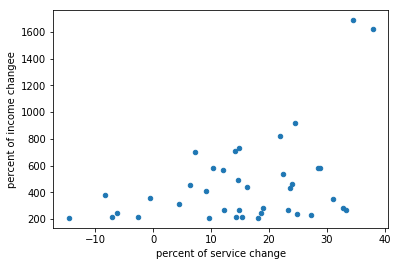

In [326]:
df_fast.plot(x='service_change',y='income_change',kind='scatter')
plt.xlabel('percent of service change')
plt.ylabel('percent of income change')

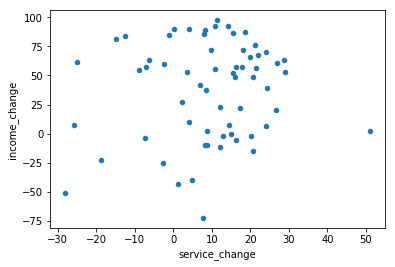

In [266]:
df_slow.plot(x='service_change',y='income_change',kind='scatter')
plt.xlabel('percent of service change')
plt.ylabel('percent of income change')

可见在收入增长较快的国家二者有一定线性关系，收入增长慢的国家二者线性关系就不那么明显了

Text(0,0.5,'percent of income change')

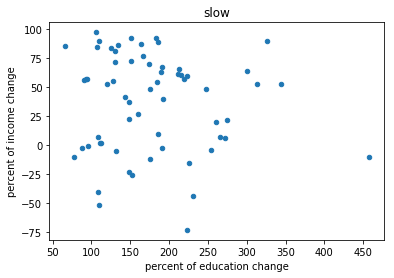

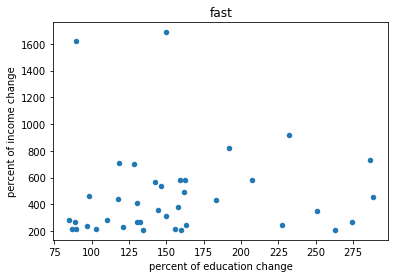

In [328]:
#查看教育年限变化与收入增长的关系
df_slow.plot(x='edu_change',y='income_change',kind= 'scatter',title='slow')
plt.xlabel('percent of education change')
plt.ylabel('percent of income change')
df_fast.plot(x='edu_change',y='income_change',kind= 'scatter',title='fast')
plt.xlabel('percent of education change')
plt.ylabel('percent of income change')
#可见在收入增长较快的国家二者相关性较强

Text(0,0.5,'percent of income change')

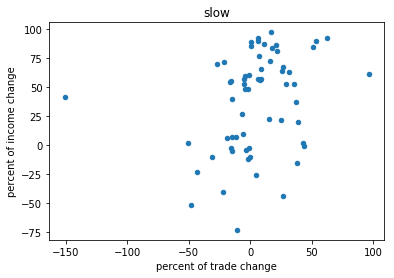

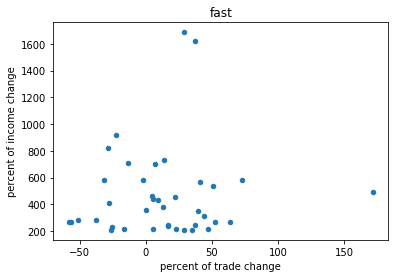

In [329]:
#查看贸易变化与收入增长的关系
df_slow.plot(x='trade_change',y='income_change',kind= 'scatter',title='slow')
plt.xlabel('percent of trade change')
plt.ylabel('percent of income change')
df_fast.plot(x='trade_change',y='income_change',kind= 'scatter',title='fast')
plt.xlabel('percent of trade change')
plt.ylabel('percent of income change')
#可见在收入增长较快的国家二者相关性较强,但关联作用复杂

Text(0,0.5,'change_rate')

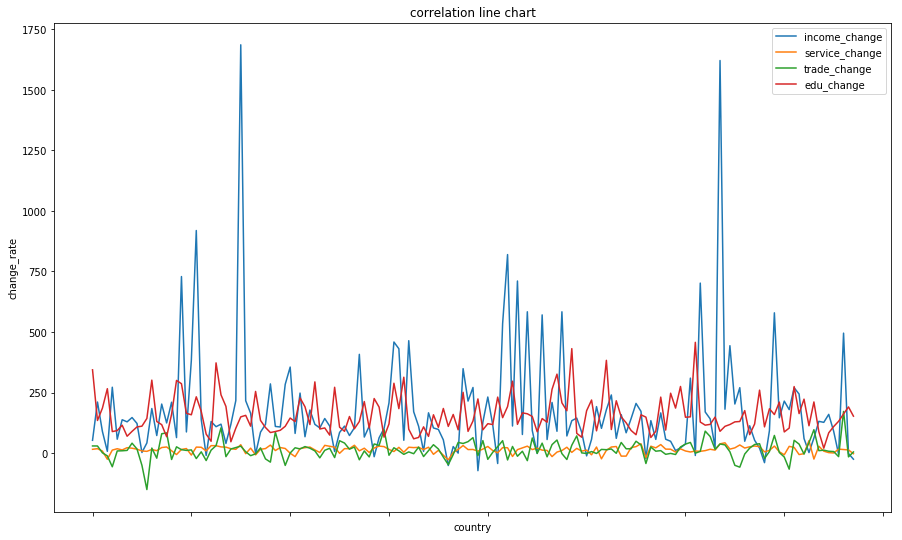

In [277]:
#绘制线图查看共变趋势
df_total.plot(kind='line',figsize=(15,9))
plt.title('correlation line chart')
plt.xlabel('country')
plt.ylabel('change_rate')

Text(0,0.5,'change_rate')

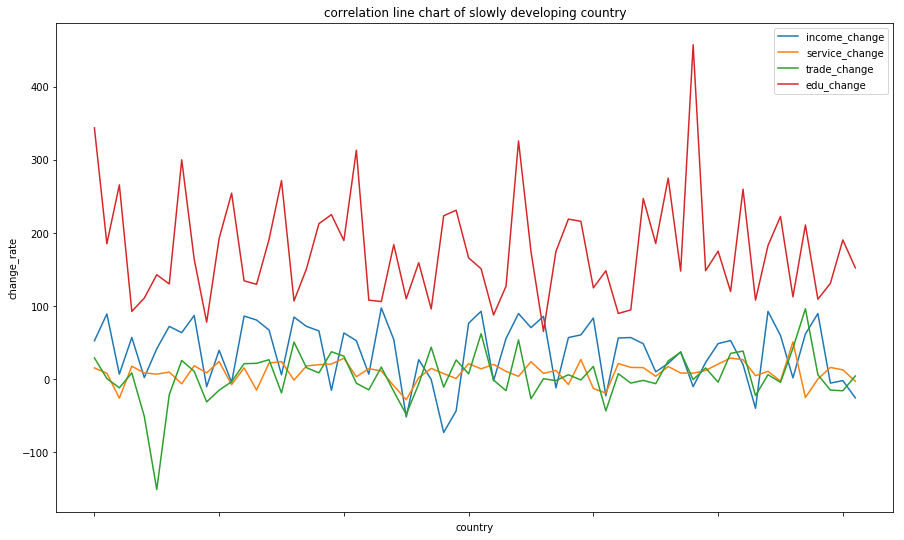

In [278]:
df_slow.plot(kind='line',figsize=(15,9))
plt.title('correlation line chart of slowly developing country')
plt.xlabel('country')
plt.ylabel('change_rate')

Text(0,0.5,'change_rate')

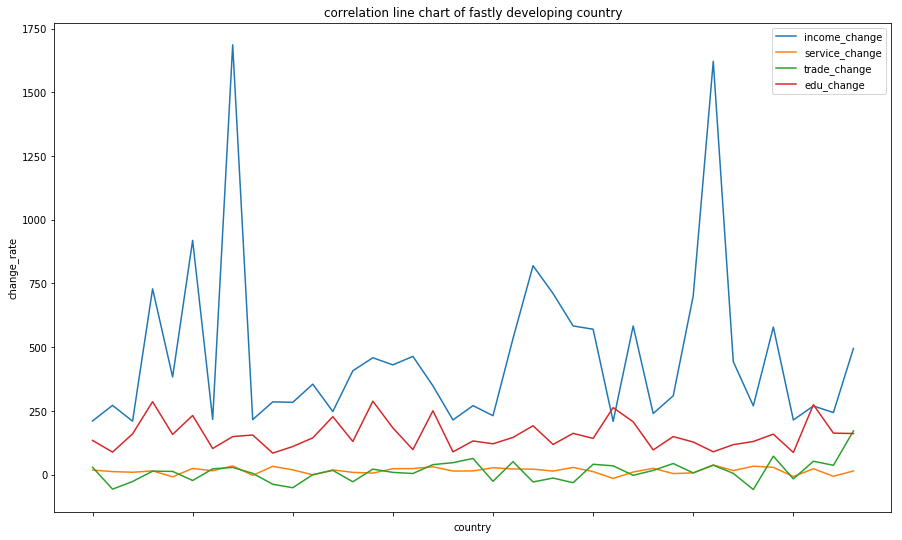

In [330]:
df_fast.plot(kind='line',figsize=(15,9))
plt.title('correlation line chart of fastly developing country')
plt.xlabel('country')
plt.ylabel('change_rate')

Text(0,0.5,'change_rate')

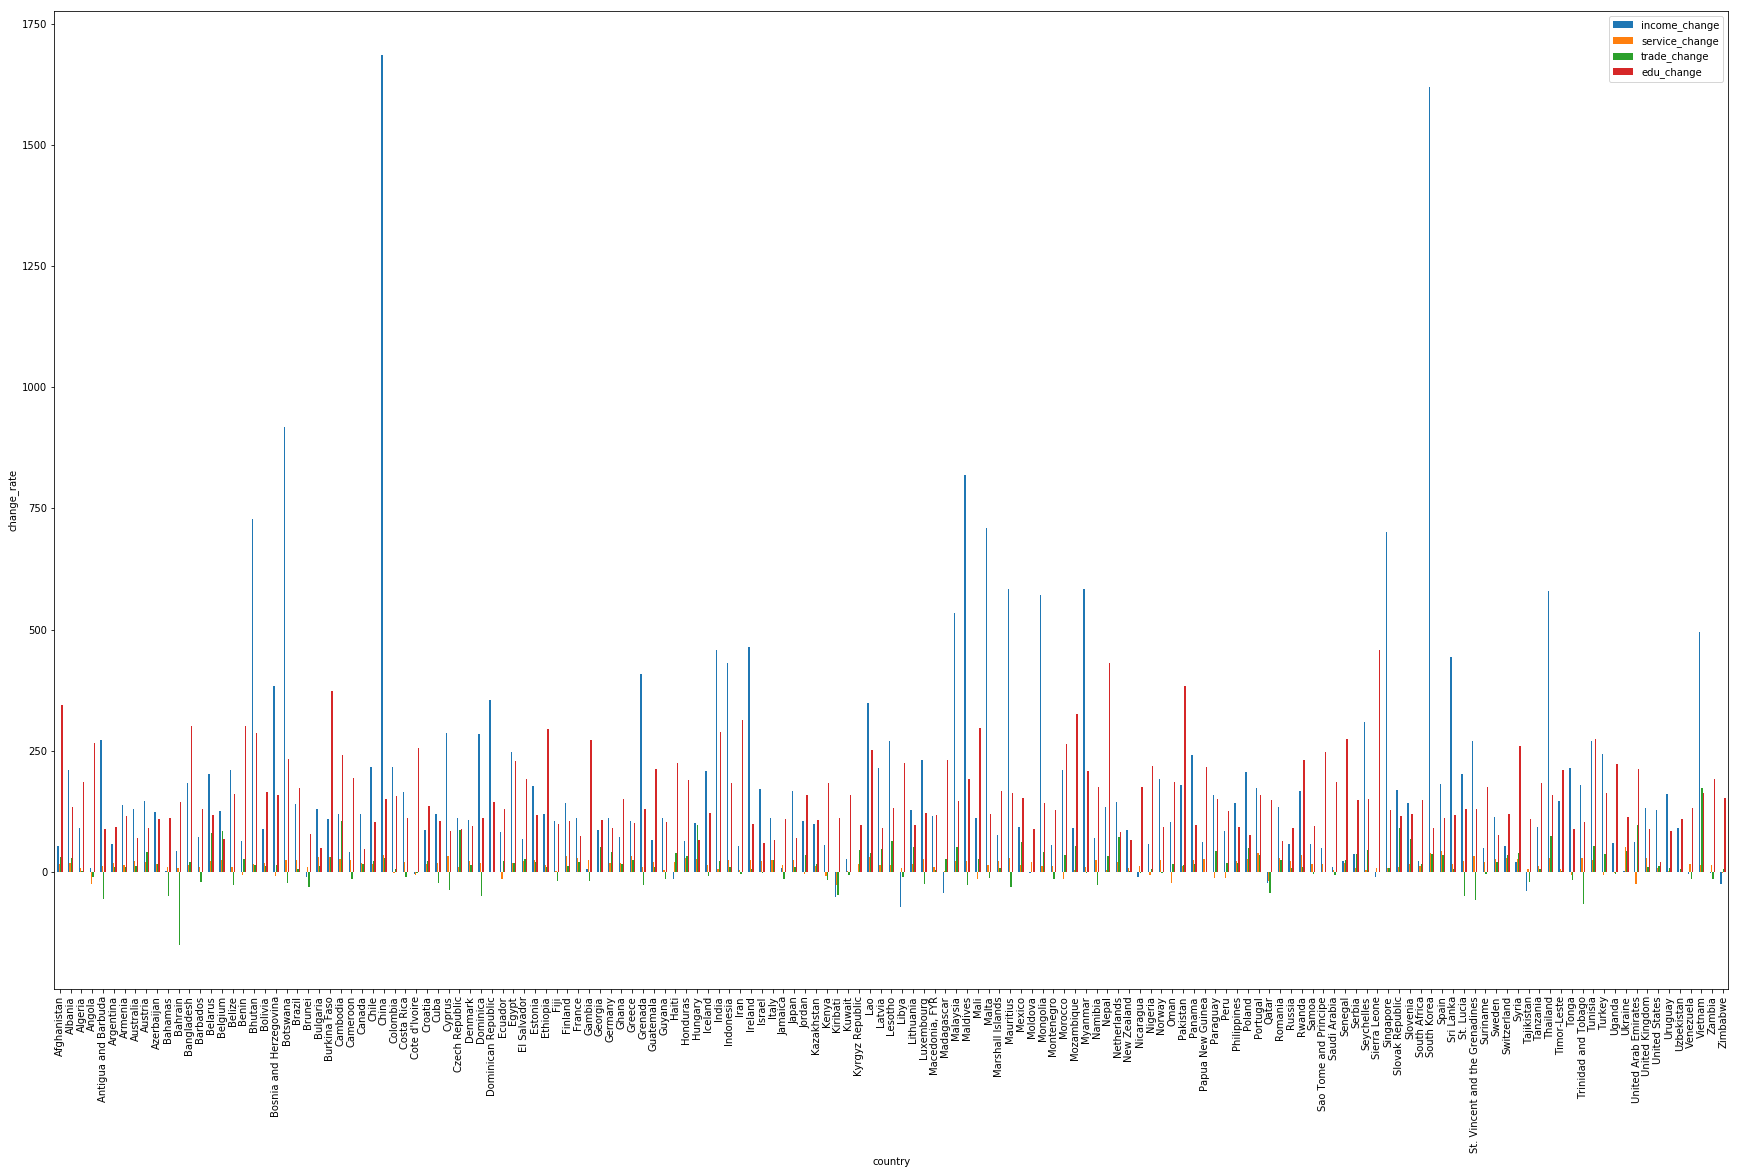

In [292]:
#再根据直方图确定国别情况
df_total.plot.bar(figsize=(30,18))
plt.xlabel('country')
plt.ylabel('change_rate')

Text(0,0.5,'change_rate')

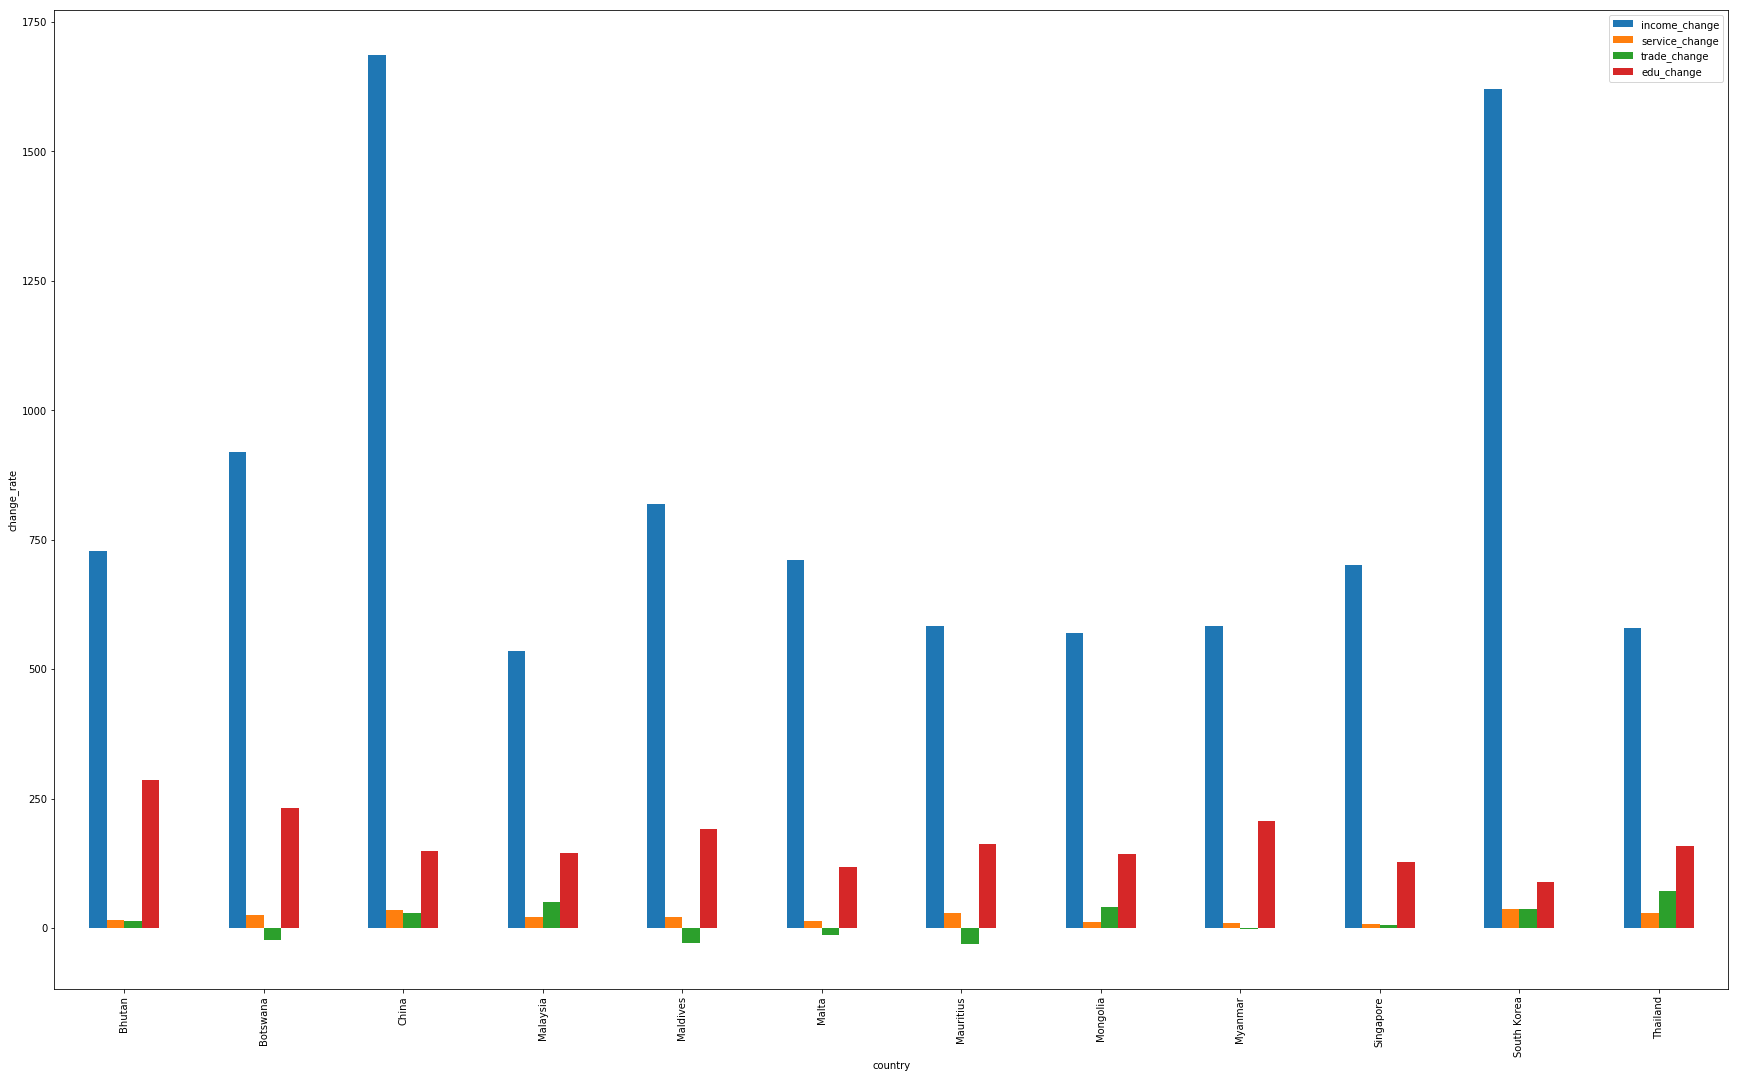

In [337]:
df_fast.plot.bar(figsize=(30,18))
plt.xlabel('country')
plt.ylabel('change_rate')

Text(0,0.5,'change_rate')

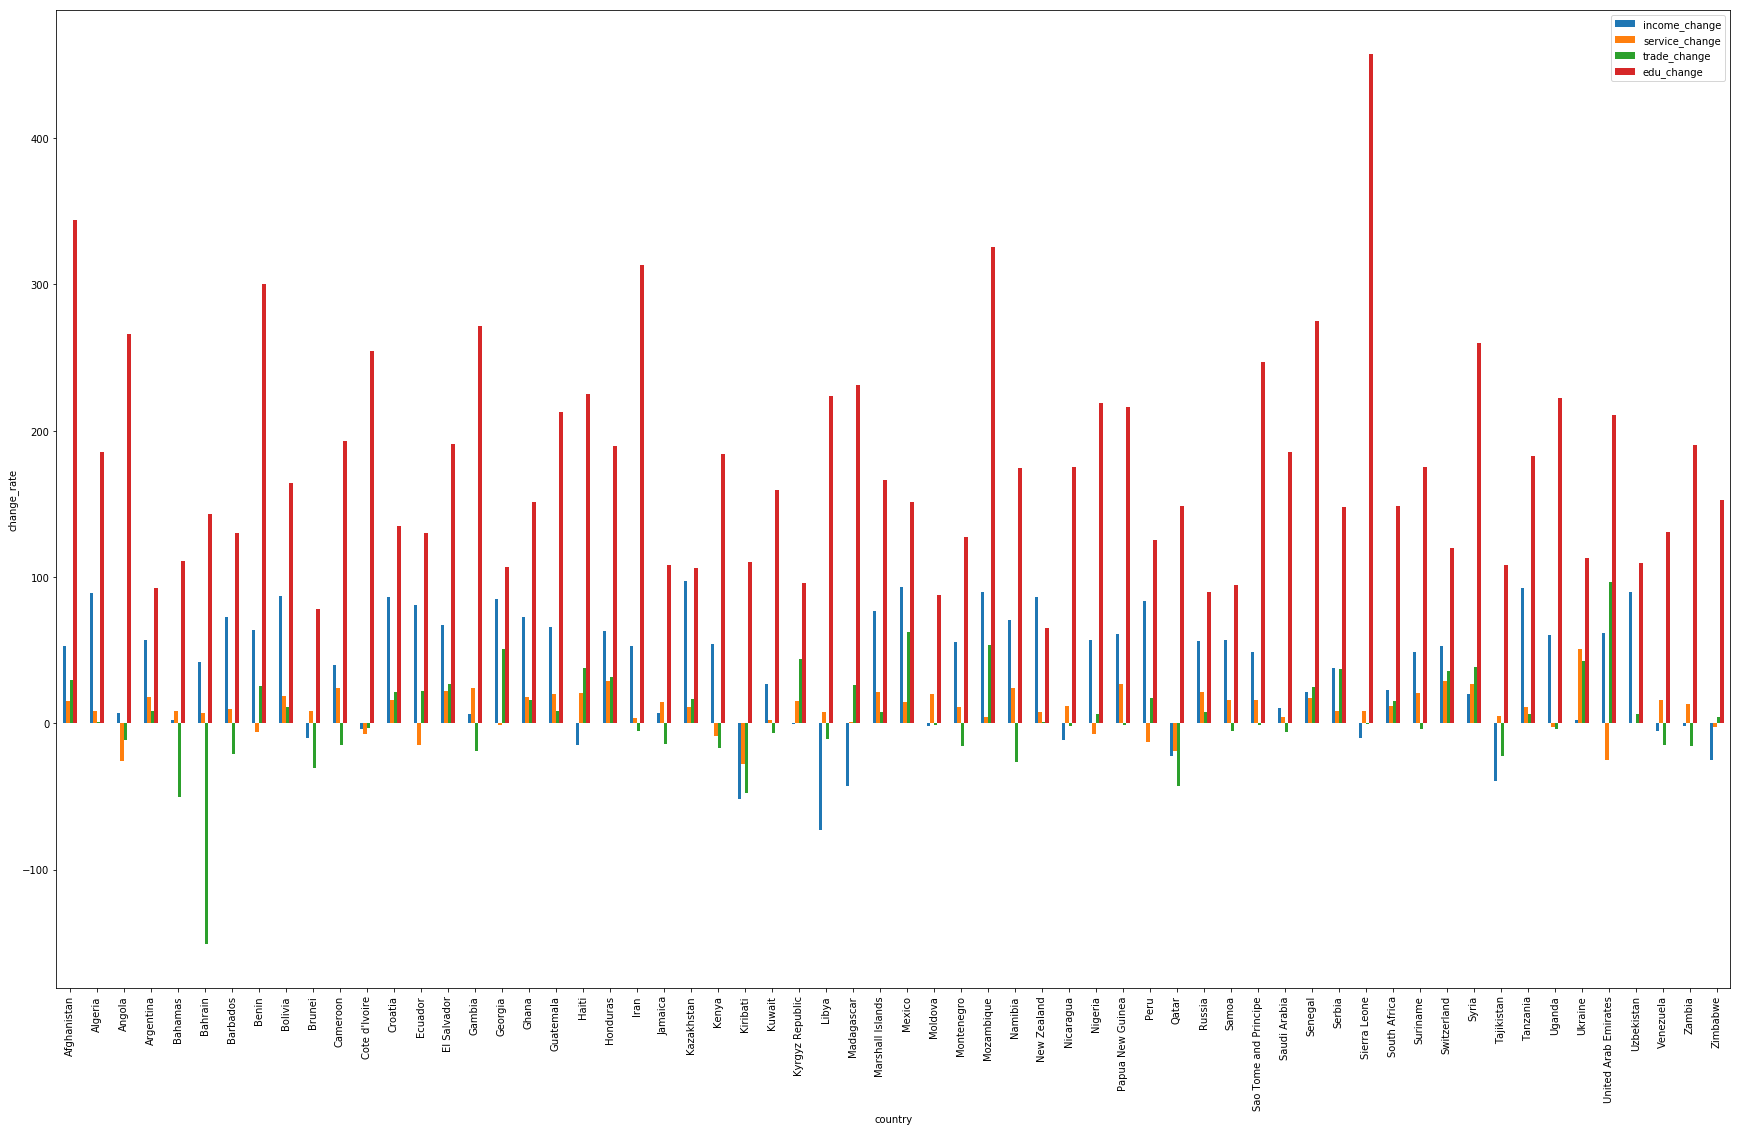

In [338]:
df_slow.plot.bar(figsize=(30,18))
plt.xlabel('country')
plt.ylabel('change_rate')

Text(0,0.5,'change_rate')

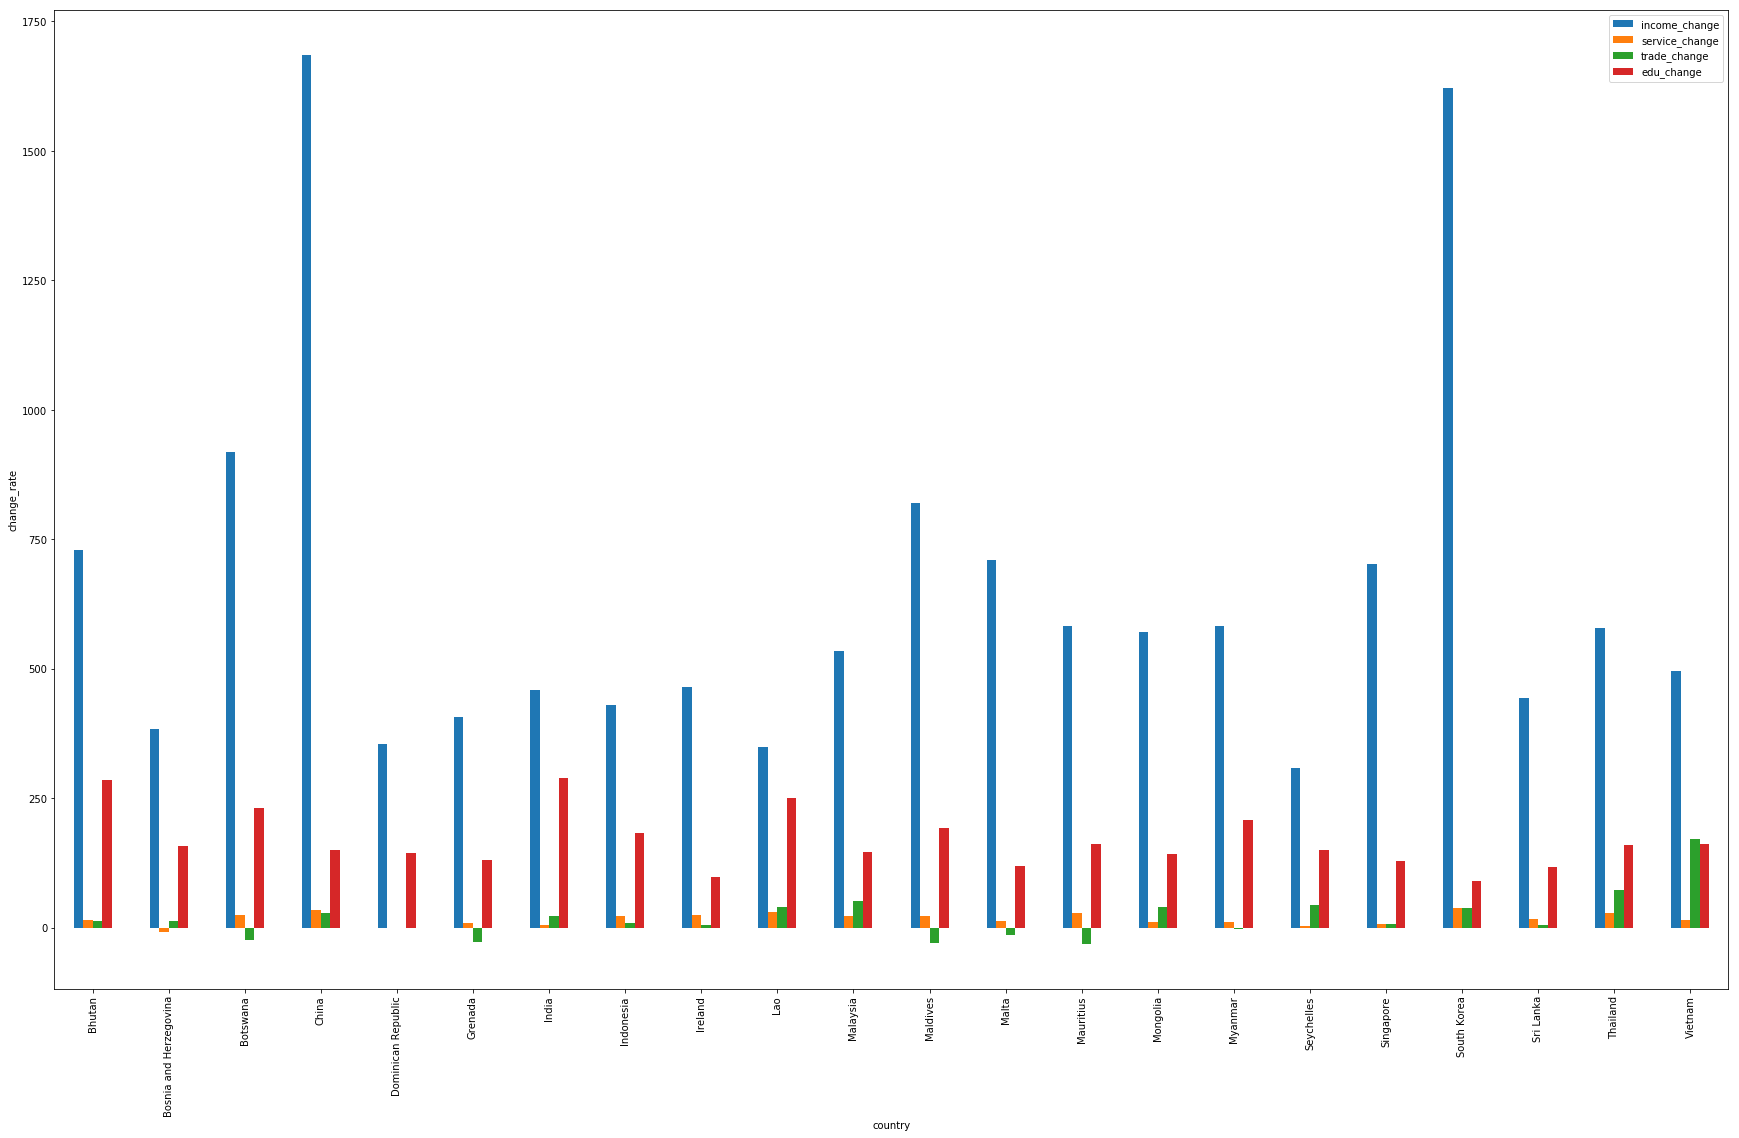

In [339]:
df_total[df_total['income_change']>300].plot.bar(figsize=(30,18))
plt.xlabel('country')
plt.ylabel('change_rate')